**Related**

There is a [neat GitHub project](https://github.com/kyp44/HER-HIM-pdfs) that prepares graphics of every state (after mirroring) and the valid moves, with colors for each move.  You could use this for an actual implementation of Boxes, as described by Garner's original [column](https://drive.google.com/file/d/12Qv41Xf_vld7VeFGgJBdhx9P9-JmqMzV/view?usp=drive_link).

In [1]:
from __future__ import annotations

from collections import Counter, defaultdict
from dataclasses import dataclass, field
import random

# Moves and States of the game

In [2]:
@dataclass
class Move:
  """A move in a hexapawn game.
  """
  src: tuple[int]  # row, col = file, rank
  dst: tuple[int]  # row, col = file, rank

  @staticmethod
  def parse(move: str) -> Move:
    """Convert a string like 'a1 a2' to a move.
    """
    def parse_loc(loc):
      file, rank = loc
      return 3 - int(rank), ord(file) - ord('a')
    src, dst = move.split(' ')
    return Move(src=parse_loc(src), dst=parse_loc(dst))

  def __str__(self) -> str:
    """Return a parseable string."""
    col_map = 'abc'
    row_map = '321'
    i, j = self.src
    i1, j1 = self.dst
    return f'{col_map[j]}{row_map[i]} {col_map[j1]}{row_map[i1]}'

  def __hash__(self):
    return hash(self.src) ^ hash(self.dst)

In [3]:
# for visualization
WHITE = '♙'
BLACK = '♟'
EMPTY = '·'
SQUARE = {1: WHITE, -1: BLACK, 0: EMPTY}
PLAYER = {1: 'white', -1: 'black', 0: '?'}

@dataclass
class State:
  """Game state for hexapawn.

  board: 3x3 matrix, encoded as a tuple of tuples,
  of 0 (unoccupied), white pawn (+1), or black pawn (-1)

  to_play: +1 or -1

  winner: 0 if game is still in progress, else +1 or -1
  """
  board: tuple[tuple[int]]
  to_play: int
  winner: int = 0
  moves: list[Move] = field(init=False)

  def __post_init__(self):
    """Cache the set of possible moves, and if there is a winner.
    """
    self.moves = self._compute_moves()
    self.winner = self._compute_winner()
    if self.winner:
      self.moves = []

  def _compute_moves(self) -> list[Move]:
    """Compute possible moves from this state."""
    def on_board(i, j) -> bool:
      return 0 <= i < 3 and 0 <= j < 3
    def empty(i, j) -> bool:
      return on_board(i, j) and self.board[i][j] == 0
    def opposing_piece(i,j) -> bool:
      return on_board(i, j) and self.board[i][j] == -self.to_play
    def players_piece(i,j) -> bool:
      return on_board(i, j) and self.board[i][j] == self.to_play
    #
    # pieces this player can move
    moveable_pieces = [
        (i,j) for i in range(3) for j in range(3) if players_piece(i,j)]
    moves = []
    row_dir = -self.to_play # direction of movement
    for i, j in moveable_pieces:
      # i1 moves the pawn forward
      i1 = i - self.to_play
      if empty(i1, j):
        moves.append(Move(src=(i, j), dst=(i1, j)))
      # capture with the pawn if possible
      for j1 in [j - 1, j + 1]:
        if opposing_piece(i1, j1):
          moves.append(Move(src=(i, j), dst=(i1, j1)))
    return moves

  def _compute_winner(self):
    """See if there is a winner for this position."""
    # case 1: if a pawn is on the back row for player they win
    for player, back_row in [(-1, 2), (+1, 0)]:
      if player in self.board[back_row]:
        return player
    # case 2: if the player can't move they lose
    # case 3: if they've lost all pieces => they have no moves and lose
    if not self.moves:
      return -self.to_play
    return 0

  @staticmethod
  def initial() -> State:
    """Initial state of board."""
    return State(to_play=1, board=((-1,-1,-1),(0,0,0),(1,1,1)))

  def render(self) -> str:
    """A printable description of the state."""
    rows = self.render_board().split('\n')
    prefixes = [' ', PLAYER[self.to_play][0], ' ']
    prefixed_rows = [f'{prefix}|{row}|' for prefix, row in zip(prefixes, rows)]
    return '\n'.join(prefixed_rows)

  def render_board(self) -> str:
    """A printable view of the board."""
    def render_row(row):
      return ''.join([f'{SQUARE[j]}' for j in row])
    return f'\n'.join([render_row(row) for row in self.board])

  def children(self) -> dict[Move. State]:
    """All possible states that can be reached from this state."""
    return {m:self.apply(m) for m in self.moves}

  def apply(self, move: Move) -> State:
    """Apply a move and return the resulting state."""
    mutable_board = [list(list(row)) for row in self.board]
    i, j = move.src
    mutable_board[i][j] = 0
    i1, j1 = move.dst
    mutable_board[i1][j1] = self.to_play
    return State(
        board=tuple(tuple(row) for row in mutable_board),
        to_play=-self.to_play)

  def __hash__(self):
    return hash(self.board) ^ hash(self.to_play)

# Game Trees

In [4]:
@dataclass
class GameTree:
  """A game tree.

  Attributes:
    root: the root state of the game
    children: maps a state to a map of moves to child states
    forced_winner: player (+1/-1) that will win from this state, or 0
    moves_till_win: number of moves from this state to end of game
  """
  root: State
  children: dict[State, dict[Move, State]] = field(init=False)

  @staticmethod
  def rooted_at(root:State) -> GameTree:
    """Build a complete game tree.
    """
    tree = GameTree(root=root)
    tree.children = {}
    tree._expand(root)
    return tree

  def _expand(self, state):
    if state not in self.children:
      self.children[state] = state.children()
      for child in self.children[state].values():
        self._expand(child)

  #
  # debugging
  #

  def pprint(self, root=None, last_move=None, depth=0, max_depth=3, fanout=99):
    """Print the game tree.
    """
    if depth >= max_depth:
      return
    state = self.root if root is None else root
    tab = '>  ' * depth
    if last_move: print(f'{tab}{last_move}')
    lines = state.render().split('\n')
    # add forced win info to rendering
    forced_winner = self.forced_winner.get(state)
    moves = self.moves_till_win.get(state)
    if moves is not None:
      moves_ch = str(moves)
      if forced_winner == +1:
        suffixes = [moves_ch, ' ', ' ']
      elif forced_winner == -1:
        suffixes = [' ', ' ', moves_ch]
      else:
        suffixes = [' ', ' ', ' ']
      lines = [f'{line}{suffix}' for line, suffix in zip(lines, suffixes)]
    for line in lines:
      print(f'{tab}{line}')
    for move, child in list(self.children[state].items())[:fanout]:
      self.pprint(child, move, depth+1, max_depth, fanout)

# Exploring the game tree

## Learning and moving

In [5]:
@dataclass
class Transition:
  """Records moving from one state to another.
  """
  state: State
  next_state: State
  move: Move

@dataclass
class GameOutcome:
  """Winner of the game and a list of all the transitions.
  """
  winner: int
  transitions: list[Transition]

@dataclass
class Strategy:
  """An abstract strategy for playing a game
  """
  tree: GameTree
  player: int

  def select_move(self, state: State) -> Move:
    """Return the next move for the given state.
    """
    raise NotImplementedError

  def train(self, outcome: GameOutcome):
    """Update the strategy based on the outcome of a game.
    """
    # default implementation for non-learners
    pass

  def rejected_moves(self) -> set[tuple[State,State]]:
    """Set of parent_state -> child_state moves that are never made.
    """
    # default implementation for non-learners
    return set()


@dataclass
class HexapawnBoxes(Strategy):
  """Martin Gardner's version of Michie's Boxes method
  """
  beads: dict[State, list[Move]] = field(init=None)

  def __post_init__(self):
    """Start out with one bead for each possible move.
    """
    self.beads = {
        box:box.moves.copy()
        for box in self.box_states(self.player)}

  def box_states(self, player: int) -> list[State]:
    """Set of states need to run the boxes algorithm for the given player.

    'Box' states must
    (1) have some legal moves - i.e., not a win for either player
    (2) be moves for the given player
    (3) not be redundant - in particular, if one state is a reflection
        of another, only one of the pair is marked as the 'box' state
    """
    return [
        s for s in self.tree.children
        if len(s.moves) > 0  and s.to_play == player and not self.redundant(s)]

  #
  # machinery to deal with reflected states
  #

  def redundant(self, state: State) -> bool:
    """Return true if there is a reflection in the tree that
    is lexigraphically larger than the given state.
    """
    reflection = self.reflected_state(state)
    return reflection in self.tree.children and reflection.board > state.board

  def reflected_state(self, state: State) -> State:
    """Find the horizontal reflection of a state."""
    reflection = tuple(tuple(reversed(row)) for row in state.board)
    return State(board=reflection, to_play=state.to_play)

  def reflected_move(state, move: Move) -> Move:
    """Find the horizontal reflection of a move."""
    def reflect_loc(loc):
      file, rank = loc
      return file, 2 - rank
    return Move(reflect_loc(move.src), reflect_loc(move.dst))

  def normalize_state(self, state: State) -> tuple[State, bool]:
    """If a state and its horizontal reflection are both
    in the game tree, we only have a box for one.  This
    returns the state for which there is a box.
    """
    if state in self.beads:
      return state, False
    reflected_state = self.reflected_state(state)
    if reflected_state in self.beads:
      return reflected_state, True
    return None, False

  def normalize_move(self, reflected: bool, move: Move) -> Move:
    """If reflected is true, return the equivalent move on
    a reflected version of the board.
    """
    return self.reflected_move(move) if reflected else move

  #
  # move selection
  #

  def select_move(self, state: State) -> Move:
    """Select a move at random, by picking one of the
    beads at random from the appropriate box.
    """
    norm_state, reflected = self.normalize_state(state)
    norm_move = random.choice(self.beads[norm_state])
    return self.normalize_move(reflected, norm_move)

  #
  # learniing
  #

  def train(self, outcome: GameOutcome):
    """Update the strategy based on the outcome of a game.
    """
    if outcome.winner == self.player:
      # no change when this player wins
      return
    # otherwise find the last move and penalize it
    for transition in reversed(outcome.transitions):
      # last move might have been on a reflected board
      # todo: make norm_state None if there's no box for it
      norm_state, reflected = self.normalize_state(transition.state)
      if norm_state is None:
        continue
      norm_move = self.normalize_move(reflected, transition.move)
      if len(self.beads[norm_state]) > 1:
        # departing from Gardner's strategy - penalize the last move
        # only if there were alternatives, so you don't ever end up
        # with an empty box
        self.beads[norm_state].remove(norm_move)
        # only update beads for the last box
        break

  #
  # support for debugging/visualization
  #

  def print_boxes(self):
    """Show all the 'boxes'"""
    for box, moves in self.beads.items():
      print(box.render())
      print([str(m) for m in moves])

  def rejected_moves(self) -> set[tuple[State,State]]:
    """Set of parent_state, child_state moves that are never made.
    """
    result = set()
    for state, move_dict in self.tree.children.items():
      for move, child in move_dict.items():
        norm_state, reflected = self.normalize_state(state)
        norm_move = self.normalize_move(reflected, move)
        if norm_state in self.beads and norm_move not in self.beads[norm_state]:
          result.add((state, child))
    return result

  def num_moves(self) -> int:
    return sum([len(moves) for moves in self.beads.values()])

@dataclass
class RandomStrategy(Strategy):
  """Pick moves at random.
  """
  def select_move(self, state: State) -> Move:
    return random.choice(state.moves)

@dataclass
class InteractiveStrategy(Strategy):
  """Ask user for moves.
  """
  def select_move(self, state: State) -> Move:
    """Get the user for a move.
    """
    def report_problem(move_str:str, issue: str):
      """User's input is somehow wrong.
      """
      print(f'{issue} move "{move_str}"')
      print('your options were:', [str(m) for m in state.moves])
    move_str = input(f'{PLAYER[state.to_play]} move? ')
    try:
      move = Move.parse(move_str)
      if move not in state.moves:
        report_problem(move_str, 'illegal')
      return move
    except Exception as ex:
      report_problem(move_str, f'syntactically incorrect [{ex=}]')
    return self.input_move(state)


## Playing one strategy against another

In [6]:
@dataclass
class Hexapawn:
  """A game of hexapawn.
  """
  white_strategy: str = 'input'
  black_strategy: str = 'random'
  tree: GameTree | None = None
  strategy: dict[int: Strategy] = field(init=False)

  def __post_init__(self):
    if self.tree is None:
      self.tree = GameTree.rooted_at(State.initial())
    # convert strategy names to Strategy objects
    def strat(abbrev, player):
      match abbrev:
        case 'random': return RandomStrategy(self.tree, player)
        case 'input': return InteractiveStrategy(self.tree, player)
        case 'boxes': return HexapawnBoxes(self.tree, player)
        case _: raise ValueError(f'unknown strategy {abbrev}')
    self.strategy = {
        -1: strat(self.black_strategy, -1),
        +1: strat(self.white_strategy, +1),
    }

  def play(self, echo: set[str] | None = None) -> Game:
    """Play a game of hexapawn.

    Echo is a set of events which will be printed on the screen.
    Valid events are 'states', 'moves', 'winner'.
    """
    if echo is None:
      echo = {'states', 'moves', 'winner'}
    state = self.tree.root
    rollout = []
    while not state.winner:
      if 'states' in echo: print('\n' + state.render())
      move = self.next_move(state)
      if 'moves' in echo: print(f'{PLAYER[state.to_play]} move: {move!s}')
      prev_state = state
      state = state.apply(move)
      rollout.append(Transition(state=prev_state, next_state=state, move=move))
    if 'states' in echo: print('\n' + state.render())
    if 'winner' in echo: print(f'{PLAYER[state.winner]} wins')
    return GameOutcome(state.winner, rollout)

  def next_move(self, state: State) -> Move | None:
    """Return the next move for the given state.
    """
    return self.strategy[state.to_play].select_move(state)

# Experiments

## Learn black's strategy against a random opponent

In [7]:
import pandas as pd
from tqdm import tqdm

def score(hp: Hexapawn, n_trials: int):
  """A number between -1 and 1 which summarizes how often each player wins.
  """
  return sum(hp.play(echo={}).winner for _ in range(n_trials)) / n_trials

def expt(white_strategy: str ='random', black_strategy: str ='boxes',
         n_games: int = 50,
         n_trials: int = 1000) -> tuple[pd.DataFrame, Hexapawn]:
  """Play multiple games of hexapawn between two learning strategies.

  white_strategy, black_strategy: passed to Hexapawn constructor
  n_games: number of games to play (and learn strategies from)
  n_trials: number of games to test the strategies on after each game played
  """
  hp = Hexapawn(white_strategy=white_strategy, black_strategy=black_strategy)
  # stats to accumulate
  def stat(hp, m):
    return dict(
        m=m,
        num_black_rejects=len(hp.strategy[-1].rejected_moves()),
        num_white_rejects=len(hp.strategy[+1].rejected_moves()),
        score=score(hp, n_trials),
    )
  rows = [stat(hp, 0)]
  for i in tqdm(range(n_games)):
    outcome = hp.play(echo={})
    for s in hp.strategy.values():
      s.train(outcome)
    rows.append(stat(hp, i+1))
  df = pd.DataFrame(rows)
  # normalize the score to percent of wins for black
  df['win_pct'] = ((df.score * -1) + 1) * 50
  return df, hp

100%|██████████| 50/50 [00:09<00:00,  5.40it/s]


final win_pct 95.19999999999999
[(-1, <class '__main__.HexapawnBoxes'>), (1, <class '__main__.RandomStrategy'>)]


<Axes: xlabel='m'>

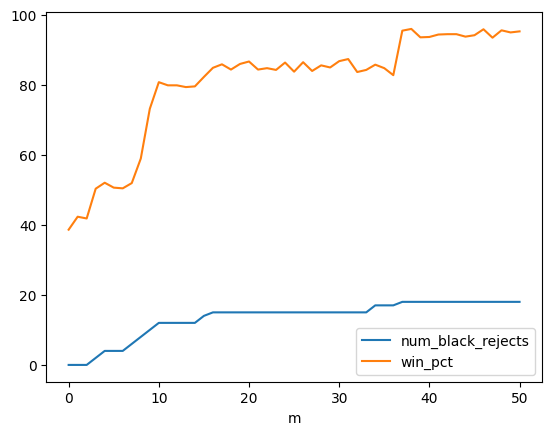

In [8]:
dfb, hpb = expt(n_trials=1000, n_games=50, white_strategy='random', black_strategy='boxes')
print('\nfinal win_pct', dfb.loc[len(dfb)-1].win_pct)
print([(p, s.__class__) for p, s in hpb.strategy.items()])
dfb.plot(x='m', y=['num_black_rejects', 'win_pct'])

100%|██████████| 50/50 [00:03<00:00, 14.59it/s]


final win_pct 31.8
[(-1, <class '__main__.RandomStrategy'>), (1, <class '__main__.HexapawnBoxes'>)]


<Axes: xlabel='m'>

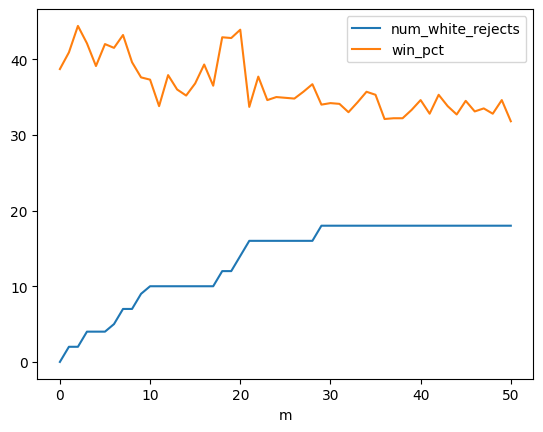

In [9]:
dfw, hpw = expt(n_trials=1000, n_games=50, white_strategy='boxes', black_strategy='random')
print('\nfinal win_pct', dfw.loc[len(dfw)-1].win_pct)
print([(p, s.__class__) for p, s in hpw.strategy.items()])
dfw.plot(x='m', y=['num_white_rejects', 'win_pct'])

## Learn black's strategy against a learned opponent

100%|██████████| 50/50 [00:03<00:00, 13.04it/s]

final win_pct 100.0


<Axes: xlabel='m'>

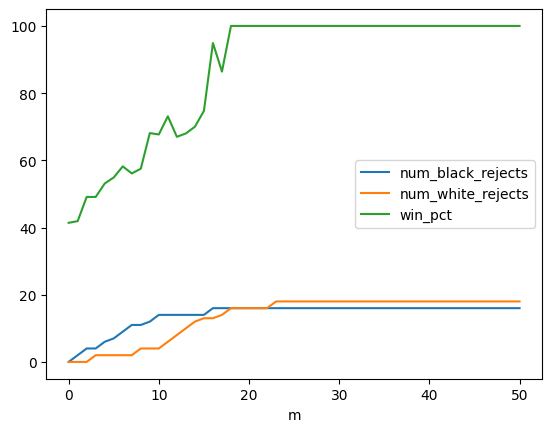

In [10]:
df, hp = expt(n_trials=1000, n_games=50, white_strategy='boxes', black_strategy='boxes')
print('final win_pct', df.loc[len(df)-1].win_pct)
df.plot(x='m', y=['num_black_rejects', 'num_white_rejects', 'win_pct'])

## Visualize a learned strategy

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

LIGHT_RED = '#ff9d9d'
LIGHT_GREEN = '#9dfabb'
LIGHT_GRAY = '#cccccc'
VERY_LIGHT_RED = '#ffcccc'
DARK_GRAY = '#f0f0f0'
WHITE = '#ffffff'

def viz(tree:GameTree,
        unused_edges:set[tuple[State,State]] | None = None):
  """Visualize a game tree.
  """

  if unused_edges is None:
    unused_edges = set()

  gr = nx.DiGraph()
  # map a numeric index of a state to its textual 'rendering'
  def render(s, i):
    return s.render().replace('w', 'r') # white replaced with red
  idx = {
      s: render(s, i)
      for i, s in enumerate(tree.children)
      }
  # map the rendering back to the state
  state = {r:s for s, r in idx.items()}
  # add edges between state indices
  for parent, children in tree.children.items():
    gr.add_edges_from([(idx[parent], idx[child]) for child in children.values()])

  # color positions by who wins
  def node_color(rendering: str):
    win_colormap = {0: WHITE, -1: LIGHT_GRAY, 1: LIGHT_RED}
    return win_colormap[state[rendering].winner]
  node_colors = [node_color(r) for r in gr]

  # color edges by player
  def edge_color(edge: tuple[int, int]) -> str:
    parent, child = edge
    if (state[parent], state[child]) in unused_edges:
      return LIGHT_GRAY if state[parent].to_play == -1 else VERY_LIGHT_RED
    return 'k' if state[parent].to_play == -1 else 'r'
  edge_colors = [edge_color(e) for e in gr.edges]

  plt.figure(figsize=(16, 8))
  pos = nx.bfs_layout(gr, start=idx[tree.root], align='horizontal', scale=20)
  #pos = nx.forceatlas2_layout(g)
  #pos = nx.kamada_kawai_layout(g, scale=10000)
  #pos = nx.spectral_layout(g)
  #pos = nx.shell_layout(g)
  nx.draw_networkx(
    gr, pos=pos, arrows=True, edge_color=edge_colors,
    font_size=8, font_family='monospace', linewidths=5,
    node_size=600, node_color=node_colors, node_shape='s')
  plt.show()


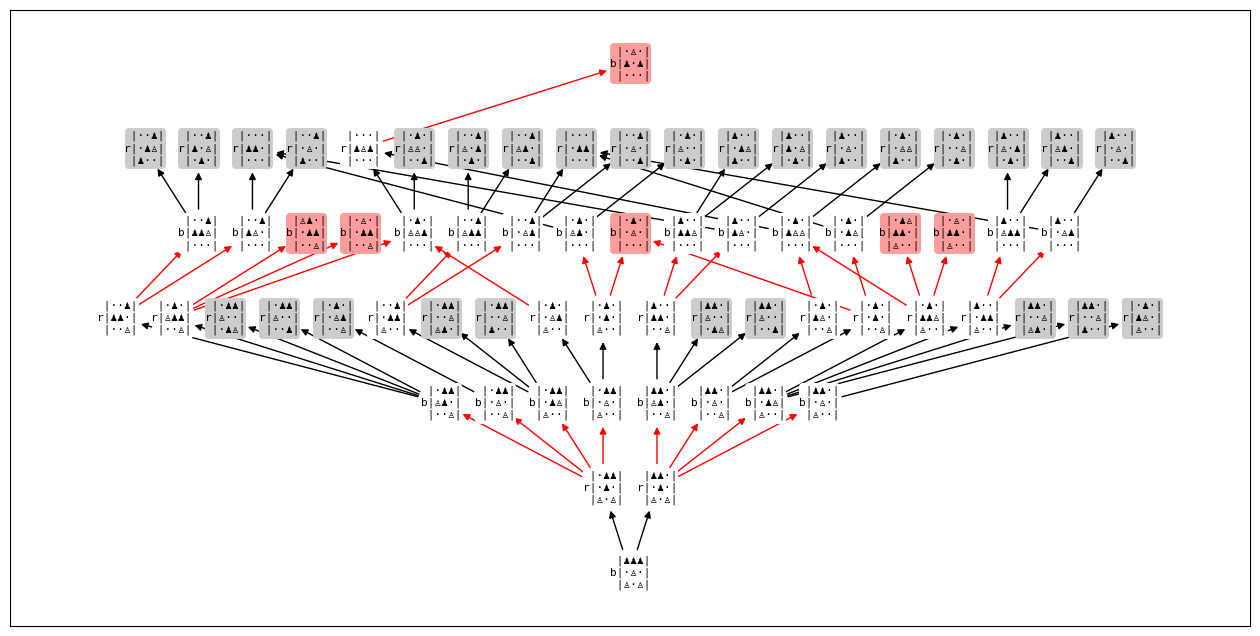

In [15]:
import copy

def prune_tree(start_tree: GameTree, rejected_moves: set[tuple[State,State]]):
  tree = copy.copy(start_tree)
  for parent, children in tree.children.items():
    for move, child in list(children.items()):
      if (parent, child) in rejected_moves:
        del tree.children[parent][move]
  reachable = set()
  def mark_reachable(state):
    reachable.add(state)
    for child in tree.children[state].values():
      mark_reachable(child)
  mark_reachable(tree.root)
  for state in set(tree.children) - reachable:
    del tree.children[state]
  return tree

def viz_subtree(hp: Hexapawn, initial_moves=[], prune=True):
    root = hp.tree.root
    for m in initial_moves:
        root = root.apply(Move.parse(m))
    rejected = (
        hp.strategy[-1].rejected_moves()
        | hp.strategy[+1].rejected_moves())
    tree = GameTree.rooted_at(root)
    if prune:
        viz(prune_tree(tree, rejected), rejected)
    else:
        viz(tree, rejected)

viz_subtree(hpb, ['b1 b2'], prune=True)